# 03 — Time Series Foundations: Unit Roots, Cointegration & VAR

This notebook builds the core time-series diagnostic layer of the project.  
It evaluates whether financial series are stationary, detects long-run equilibrium relationships between major equity indices, and estimates multivariate structures (VAR/VECM) that capture the dynamic interactions driving market comovements. This forms the analytical bridge between the linear-factor econometrics of Notebook 02 and the volatility/forecasting modules that follow.

### Objectives
- Apply ADF and KPSS tests to determine stationarity and integration order.  
- Identify which variables are I(0) vs I(1) and verify consistency across tests.  
- Perform Johansen cointegration tests to detect long-run equilibrium relations.  
- Select optimal VAR lag orders using AIC, BIC, HQIC, and FPE.  
- Fit VAR models for stationary setups and validate their stability via root modulus analysis.  
- Estimate VECM models when cointegration is present and interpret adjustment speeds.  
- Generate Impulse Response Functions (IRFs) and Forecast Error Variance Decomposition (FEVD).  
- Export IRFs, FEVD tables, and model summaries for Power BI integration.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/excess_returns_panel.csv` | Excess returns for IBEX, SP500, NASDAQ, EuroStoxx, VIX, EURUSD. |
| `/data/processed/factor_returns.csv` | Cleaned FF5 + Momentum factor set. |
| `/data/processed/log_returns.csv` | Log returns used for alignment and differencing. |

### Outputs
| File | Description |
|------|-------------|
| `/figures/03_Time_Series_Unit_Roots/ADF_KPSS_summary.csv` | Stationarity test summary. |
| `/figures/03_Time_Series_Cointegration/` | Johansen tables, rank plots. |
| `/figures/03_VAR/irf_VAR_*.png` | IRF plots for VAR-selected models. |
| `/data/powerbi/var_vecm_outputs.csv` | IRFs, FEVDs, and adjustment coefficients in long format. |

### Tests Performed
| Test | Purpose |
|------|---------|
| **ADF** | Detect unit roots; check if a series is *not* stationary. |
| **KPSS** | Complementary stationarity test; guards against ADF false negatives. |
| **Johansen Trace / Max-Eigen** | Determine cointegration rank and long-run relations. |
| **VAR Lag Selection** | Choose optimal dynamic structure. |
| **Stability (AR roots)** | Confirm VAR/VECM is dynamically well-behaved. |
| **IRF / FEVD** | Understand shock propagation and contribution to forecast variance. |

### Notebook Structure
1. **Load and Prepare Data**  
   Import IBEX35 and EUROSTOXX50 prices, convert to log-levels, and compute first differences.
2. **Unit-Root Tests (ADF & KPSS)**  
   Evaluate stationarity in log-prices and their first differences to classify each series as \(I(0)\) or \(I(1)\).
3. **Pairwise Cointegration (Engle–Granger)**  
   Test for long-run equilibrium between IBEX35 and EUROSTOXX50 via residual-based ADF.
4. **Load Return Panel**  
   Import multivariate log-returns prepared in Notebook 1.
5. **VAR Modelling (Lag Selection, Estimation, Stability)**  
   Select the optimal lag order using AIC/BIC/HQIC, estimate the VAR model, and verify dynamic stability using the AR-root modulus.
6. **Impulse Response Functions (IRFs)**  
   Compute IRFs, save the figure, and reshape the results into long format for Power BI.
7. **Power BI Export**  
   Export the IRF table as CSV for dashboard integration.

This notebook clarifies which series can be modelled in levels, which require differencing, and whether markets share long-run equilibria. These insights guide all subsequent steps — volatility modelling, forecast evaluation, and risk analytics.


### Section 1. Data Loading and Preprocessing

We begin by importing the required packages, configuring paths, and ensuring the folder structure for figures and Power BI exports is in place.  
Next, we load the European equity indices (IBEX 35 and EUROSTOXX 50) from the processed dataset and prepare the two transformations essential for time-series analysis:

- **Log-levels**, used in unit-root and cointegration testing to analyse long-run behaviour.  
- **First differences of log-prices**, which approximate daily returns and are typically stationary.

These series are the foundation for the unit-root tests, Engle–Granger cointegration analysis, and VAR modelling developed later in the notebook.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Project structure (same idea as N01/N02)
PROJECT_ROOT = Path("..")
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
DATA_POWERBI_DIR = PROJECT_ROOT / "data" / "powerbi"
FIG_DIR = PROJECT_ROOT / "figures" / "03_UnitRoots_Cointegration_VAR"

# Create folders if needed
DATA_POWERBI_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Processed data dir:", DATA_PROCESSED_DIR)
print("Power BI dir:", DATA_POWERBI_DIR)
print("Figures dir:", FIG_DIR)


Processed data dir: ../data/processed
Power BI dir: ../data/powerbi
Figures dir: ../figures/03_UnitRoots_Cointegration_VAR


In [2]:
# Load European equity indices (IBEX35 & EUROSTOXX50)

prices_wide_path = DATA_PROCESSED_DIR / "prices_wide.csv"
prices_wide = (
    pd.read_csv(prices_wide_path, parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)

# Keep only European equity indices
cols_eu = ["IBEX35", "EUROSTOXX50"]
prices_eu = prices_wide[cols_eu].dropna()

print("Price sample (levels):")
display(prices_eu.head())

# Log price levels (for unit roots & cointegration)
log_prices = np.log(prices_eu)

# First differences of log prices (approx. returns)
dlog_prices = log_prices.diff().dropna()

print("\nLog-price sample:")
display(log_prices.head())

print("\nFirst differences of log-prices (dlog):")
display(dlog_prices.head())


Price sample (levels):


,IBEX35,EUROSTOXX50
Date,,
2000-01-03,11609.988281,4181.029785
2000-01-04,11206.587891,4181.029785
2000-01-05,10863.088867,4181.029785
2000-01-06,10863.088867,4181.029785
2000-01-07,11102.388672,4181.029785



Log-price sample:


,IBEX35,EUROSTOXX50
Date,,
2000-01-03,9.359621,8.338313
2000-01-04,9.324257,8.338313
2000-01-05,9.293126,8.338313
2000-01-06,9.293126,8.338313
2000-01-07,9.314916,8.338313



First differences of log-prices (dlog):


,IBEX35,EUROSTOXX50
Date,,
2000-01-04,-0.035364,0.0
2000-01-05,-0.031131,0.0
2000-01-06,0.000000,0.0
2000-01-07,0.021790,0.0
2000-01-10,0.006366,0.0


### 2. Unit Root Testing: ADF and KPSS

In this section we evaluate the time-series properties of IBEX 35 and EUROSTOXX 50.  
Understanding whether a series is stationary or not is important to determine which models can be applied later.

To classify each index, we apply two complementary tests:

- **ADF (Augmented Dickey–Fuller)**  
  Null hypothesis: the series has a unit root (non-stationary).  
  Rejecting the null → evidence of stationarity.

- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**  
  Null hypothesis: the series is stationary.  
  Rejecting the null → evidence of non-stationarity.

In [3]:
# Unit root tests: ADF and KPSS

def run_adf(series, name, maxlag=None):
    """Augmented Dickey-Fuller test."""
    res = adfuller(series, maxlag=maxlag, autolag="AIC")
    test_stat, pvalue, usedlag, nobs = res[0], res[1], res[2], res[3]
    print(f"\nADF test for {name}:")
    print(f"  Test statistic: {test_stat:.4f}")
    print(f"  p-value:        {pvalue:.4f}")
    print(f"  Used lags:      {usedlag}")
    print(f"  Observations:   {nobs}")

def run_kpss_test(series, name, regression="c"):
    """KPSS stationarity test (H0: series is stationary)."""
    stat, pvalue, lags, crit = kpss(series, regression=regression, nlags="auto")
    print(f"\nKPSS test for {name} (reg='{regression}'):")
    print(f"  Test statistic: {stat:.4f}")
    print(f"  p-value:        {pvalue:.4f}")
    print(f"  Used lags:      {lags}")


# 1) Tests on log-price levels (we expect unit roots)
for col in log_prices.columns:
    run_adf(log_prices[col], f"{col} (log level)")
    run_kpss_test(log_prices[col], f"{col} (log level)", regression="c")


# 2) Tests on first differences of log prices (we expect stationarity)
for col in dlog_prices.columns:
    run_adf(dlog_prices[col], f"{col} (dlog)")
    run_kpss_test(dlog_prices[col], f"{col} (dlog)", regression="c")



ADF test for IBEX35 (log level):
  Test statistic: -2.6426
  p-value:        0.0845
  Used lags:      18
  Observations:   6492

KPSS test for IBEX35 (log level) (reg='c'):
  Test statistic: 0.5622
  p-value:        0.0277
  Used lags:      51

ADF test for EUROSTOXX50 (log level):
  Test statistic: -1.7426
  p-value:        0.4093
  Used lags:      34
  Observations:   6476

KPSS test for EUROSTOXX50 (log level) (reg='c'):
  Test statistic: 2.3505
  p-value:        0.0100
  Used lags:      51


/tmp/ipykernel_2284/1998054450.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pvalue, lags, crit = kpss(series, regression=regression, nlags="auto")



ADF test for IBEX35 (dlog):
  Test statistic: -19.4593
  p-value:        0.0000
  Used lags:      17
  Observations:   6492

KPSS test for IBEX35 (dlog) (reg='c'):
  Test statistic: 0.0707
  p-value:        0.1000
  Used lags:      12


/tmp/ipykernel_2284/1998054450.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, lags, crit = kpss(series, regression=regression, nlags="auto")



ADF test for EUROSTOXX50 (dlog):
  Test statistic: -14.5012
  p-value:        0.0000
  Used lags:      33
  Observations:   6476

KPSS test for EUROSTOXX50 (dlog) (reg='c'):
  Test statistic: 0.1388
  p-value:        0.1000
  Used lags:      9


/tmp/ipykernel_2284/1998054450.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, lags, crit = kpss(series, regression=regression, nlags="auto")


**Interpretation of results**

1. Log-levels (prices):
- **ADF:** p-values for both indices are above 0.05 → we fail to reject the null hypothesis of a unit root*. There is no evidence of stationarity in levels.  
- **KPSS:** p-values are low (≈ 0.01–0.03) → we fail to reject the null hypothesis of stationarity.  
→ Both tests, despite having opposite null hypotheses, lead to the same conclusion: log-level prices are non-stationary and integrated of order one, I(1).

Economically, this implies that equity prices behave as random walks: shocks to prices have permanent effects, there is no tendency to revert to a fixed mean, and the variance grows over time.

2. First differences (dlog, returns):  
- **ADF:** the unit root hypothesis is strongly rejected (p ≈ 0.0000), providing clear evidence against non-stationarity.  
- **KPSS:** stationarity is not rejected (p ≈ 0.10).  
→ Again, both tests agree: first differences are stationary, I(0).

This indicates that while price levels absorb information permanently, returns exhibit stable statistical properties and fluctuate around a constant mean. Shocks to returns are transitory and do not accumulate over time.

Overall, the results confirm the expected behaviour of equity markets: prices follow random walks, whereas returns are stationary. Establishing this distinction is essential before proceeding to cointegration analysis and before specifying a valid multivariate dynamic model (VAR in differences or VECM, depending on the presence of cointegration) in the next section of the notebook.


### 3. Engle–Granger Cointegration Test (IBEX35 vs EUROSTOXX50)

In this section, we examine whether IBEX 35 and EUROSTOXX 50 share a long-run equilibrium relationship.  
Cointegration implies that, although each index is individually non-stationary, a specific linear combination of them remains stable over time.  
For two equity markets that are economically linked, cointegration would indicate that their prices do not drift apart indefinitely and that deviations from equilibrium are mean-reverting.

To test this, we apply the **Engle–Granger two-step procedure**:

1. **Long-run regression**  
   We regress IBEX35 (log-level) on EUROSTOXX50 (log-level) using OLS:  
   $$
   IBEX_t = \alpha + \beta\,\text{EUROSTOXX}_t + \varepsilon_t.
   $$
   This captures the potential long-run relation between the indices.

2. **ADF test on residuals**  
   If the residuals are **stationary**, the two series are cointegrated.  
   If they remain non-stationary, no long-run equilibrium exists.

In [4]:
# Engle–Granger Cointegration Test (IBEX35 vs EUROSTOXX50)

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

y = log_prices["IBEX35"]
x = log_prices["EUROSTOXX50"]

# 1) Run OLS: IBEX35 = α + β * EUROSTOXX50 + ε
x_const = sm.add_constant(x)
model_coint = sm.OLS(y, x_const).fit()

print(model_coint.summary())

# 2) Extract residuals
residuals = model_coint.resid

# 3) ADF test on residuals (Engle–Granger step 2)
adf_resid = adfuller(residuals, autolag="AIC")

print("\n=============== Engle–Granger Cointegration Test ===============")
print("ADF statistic on residuals:", adf_resid[0])
print("p-value:", adf_resid[1])
print("Used lags:", adf_resid[2])
print("Observations:", adf_resid[3])

# Critical values
print("\nCritical values:")
for k, v in adf_resid[4].items():
    print(f"  {k}: {v}")


                            OLS Regression Results                            
Dep. Variable:                 IBEX35   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     315.6
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           5.55e-69
Time:                        12:01:13   Log-Likelihood:                 1579.6
No. Observations:                6511   AIC:                            -3155.
Df Residuals:                    6509   BIC:                            -3142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4733      0.095     79.004      

### Results

- The regression produces a statistically significant coefficient (β ≈ 0.205), suggesting a positive long-run association.  
- However, the ADF test on the residuals yields:  
  - Test statistic ≈ −2.39  
  - p-value ≈ 0.14  
  - Critical value at 5% ≈ −2.86  

Since the statistic is not lower than the 5% or 10% critical values, we fail to reject the null hypothesis of a unit root in the residuals.

**Conclusion:**  
There is no evidence of cointegration between IBEX 35 and EUROSTOXX 50 in this sample.  
Although the indices move together to some extent (as shown by β > 0), their deviations do not appear to be mean-reverting.  
This result supports modelling them later using VAR in differences rather than a VECM.


### Section 4. Loading Log-Returns for Multivariate Modelling

We import the full log-return panel generated in Notebook 1.  
These stationary return series will be used for the VAR, lag selection, and Johansen cointegration analyses later in the notebook.


In [6]:
# Load log-returns exported from Notebook 1

from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path("..")
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# Load log returns
log_returns_path = PROCESSED_DIR / "log_returns.csv"
dlog = pd.read_csv(log_returns_path, parse_dates=["Date"]).set_index("Date")

print("Log returns loaded:")
display(dlog.head())
print(dlog.columns)


Log returns loaded:


,EURUSD,SP500,IBEX35,NASDAQ100,EUROSTOXX50,VIX
Date,,,,,,
2000-01-04,0.0,-0.039099,-0.035364,-0.066635,0.0,0.109441
2000-01-05,0.0,0.001920,-0.031131,-0.011027,0.0,-0.022464
2000-01-06,0.0,0.000955,0.000000,-0.048636,0.0,-0.026085
2000-01-07,0.0,0.026730,0.021790,0.054971,0.0,-0.169424
2000-01-10,0.0,0.011128,0.006366,0.051843,0.0,-0.000461


Index(['EURUSD', 'SP500', 'IBEX35', 'NASDAQ100', 'EUROSTOXX50', 'VIX'], dtype='object')


In [7]:
# Prepare data for VAR 

# Select log-returns for the two assets
df_var = dlog[["IBEX35", "EUROSTOXX50"]].dropna()

print("VAR dataset preview:")
display(df_var.head())

print("\nNumber of observations:", len(df_var))


VAR dataset preview:


,IBEX35,EUROSTOXX50
Date,,
2000-01-04,-0.035364,0.0
2000-01-05,-0.031131,0.0
2000-01-06,0.000000,0.0
2000-01-07,0.021790,0.0
2000-01-10,0.006366,0.0



Number of observations: 6510


### 5. VAR Modelling: Lag Selection, Estimation and Stability

In this section we construct the Vector Autoregression (VAR) that models the joint dynamics of IBEX35 and EUROSTOXX50 daily returns. Since Section 3 showed that the indices are not cointegrated, the correct specification is a VAR in first differences rather than a VECM.

We proceed in three steps:

#### **Step 1 — Lag Selection**

We estimate a sequence of candidate VAR models with up to 20 lags and compare them using the most common information criteria (AIC, BIC, HQC, FPE).  
Daily financial returns typically exhibit short-term autocorrelation coming from market microstructure, so several lags may be needed.

The selection table indicates that AIC reaches its minimum at lag 3, and FPE also supports this choice.  
Thus, we set the model to VAR(3).

#### **Step 2 — Estimating the VAR(3)**

We fit the VAR with 3 lags on the stationary log-return series.  
The results show:

- Only a few lagged coefficients are statistically significant, which is typical in equity return data (weak short-run predictability).  
- The largest signal appears in the EUROSTOXX50 equation, where lagged IBEX35 and lagged EUROSTOXX50 both have significant effects.  
- The residual correlation between the equations is around 0.77, confirming strong contemporaneous comovement between the two markets even if predictive relations are limited.

This model provides the dynamic structure needed to compute IRFs and examine shock propagation.

#### **Step 3 — Stability Check**

A valid VAR must be stable, meaning all roots of the characteristic polynomial lie outside the unit circle.  
Using `var_results.roots`, we find that all moduli are around 2.9–3.1, far above 1.

→ The VAR(3) is stable, ensuring that:

- IRFs decay properly,  
- the system does not explode, and  
- Forecasting is well-defined.

In [8]:
# VAR Lag Selection (AIC, BIC, HQC)

from statsmodels.tsa.api import VAR

# Fit automatic lag selection
model = VAR(df_var)

# Allow up to 20 lags (typical for daily data)
lag_results = model.select_order(20)

print("Lag order selection:")
print(lag_results.summary())

# Extract the best lag according to AIC
best_lag = lag_results.aic

print("\nSelected lag (AIC):", best_lag)


/home/apalo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag order selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.37     -18.37*   1.053e-08      -18.37
1       -18.37      -18.37   1.051e-08     -18.37*
2       -18.37      -18.36   1.051e-08      -18.37
3      -18.37*      -18.36  1.050e-08*      -18.37
4       -18.37      -18.35   1.050e-08      -18.37
5       -18.37      -18.35   1.050e-08      -18.36
6       -18.37      -18.34   1.051e-08      -18.36
7       -18.37      -18.34   1.051e-08      -18.36
8       -18.37      -18.34   1.051e-08      -18.36
9       -18.37      -18.33   1.052e-08      -18.36
10      -18.37      -18.33   1.052e-08      -18.35
11      -18.37      -18.32   1.053e-08      -18.35
12      -18.37      -18.32   1.053e-08      -18.35
13      -18.37      -18.31   1.053e-08      -18.35
14      -18.37      -18.31   1.055e-08      -18.35
15      -18.37      -18.30   1.054e-08      -18.35
16      -1

In [9]:
# Estimate VAR(p) model with selected lag = 3

from statsmodels.tsa.api import VAR

p = 3  # Selected lag
var_model = VAR(df_var)
var_results = var_model.fit(p)

print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Dec, 2025
Time:                     12:10:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.3566
Nobs:                     6507.00    HQIC:                  -18.3662
Log likelihood:           41318.7    FPE:                1.05069e-08
AIC:                     -18.3712    Det(Omega_mle):     1.04844e-08
--------------------------------------------------------------------
Results for equation IBEX35
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000010         0.000173            0.060           0.952
L1.IBEX35              0.002843         0.019529            0.146           0.884
L1.EUROSTOXX50        -0.011994         0.023609       

/home/apalo/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# VAR stability check 

modulus = np.abs(var_results.roots)

print("Modulus of VAR roots:")
print(modulus)

print("\nIs VAR stable according to statsmodels?:", var_results.is_stable)

if all(modulus > 1):
    print(" VAR is stable: all roots are outside the unit circle (stationary).")
else:
    print(" Some roots are ≤ 1. The VAR may be unstable.")


Modulus of VAR roots:
[3.10114057 3.10114057 3.08211719 3.08211719 2.91565499 2.91565499]

Is VAR stable according to statsmodels?: <bound method VARProcess.is_stable of <statsmodels.tsa.vector_ar.var_model.VARResults object at 0x733ad16d3d10>>
✓ VAR is stable: all roots are outside the unit circle (stationary).


### 6. Impulse Response Functions (IRFs) and Interpretation

With the VAR(3) model estimated and validated as stable, we examine how shocks in one market affect the other over time.  
IRFs decompose the dynamic structure of the VAR and allow us to visualise short-run transmission mechanisms between IBEX35 and EUROSTOXX50.

**What is computed here:**

1. We generate 20-day impulse responses for each shock–response pair:
   - IBEX35 → IBEX35  
   - EUROSTOXX50 → IBEX35  
   - IBEX35 → EUROSTOXX50  
   - EUROSTOXX50 → EUROSTOXX50  
   Each blue line shows the estimated response, while dashed lines show ±1 standard-error confidence bands.

2. The full IRF array is reshaped into a long-format table (Horizon, Response, Shock, IRF), which is exported as a CSV for Power BI.  
   This enables interactive visualisation of shock propagation across different horizons.


✓ IRF figure saved to: ../figures/03_UnitRoots_Cointegration_VAR/irf_VAR_IBEX_EUROSTOXX.png
✓ IRF long-format table exported to: ../data/powerbi/irf_VAR_IBEX_EUROSTOXX_long.csv


,Horizon,Response,Shock,IRF
0,0,IBEX35,IBEX35,1.000000
1,0,IBEX35,EUROSTOXX50,0.000000
2,0,EUROSTOXX50,IBEX35,0.000000
3,0,EUROSTOXX50,EUROSTOXX50,1.000000
4,1,IBEX35,IBEX35,0.002843


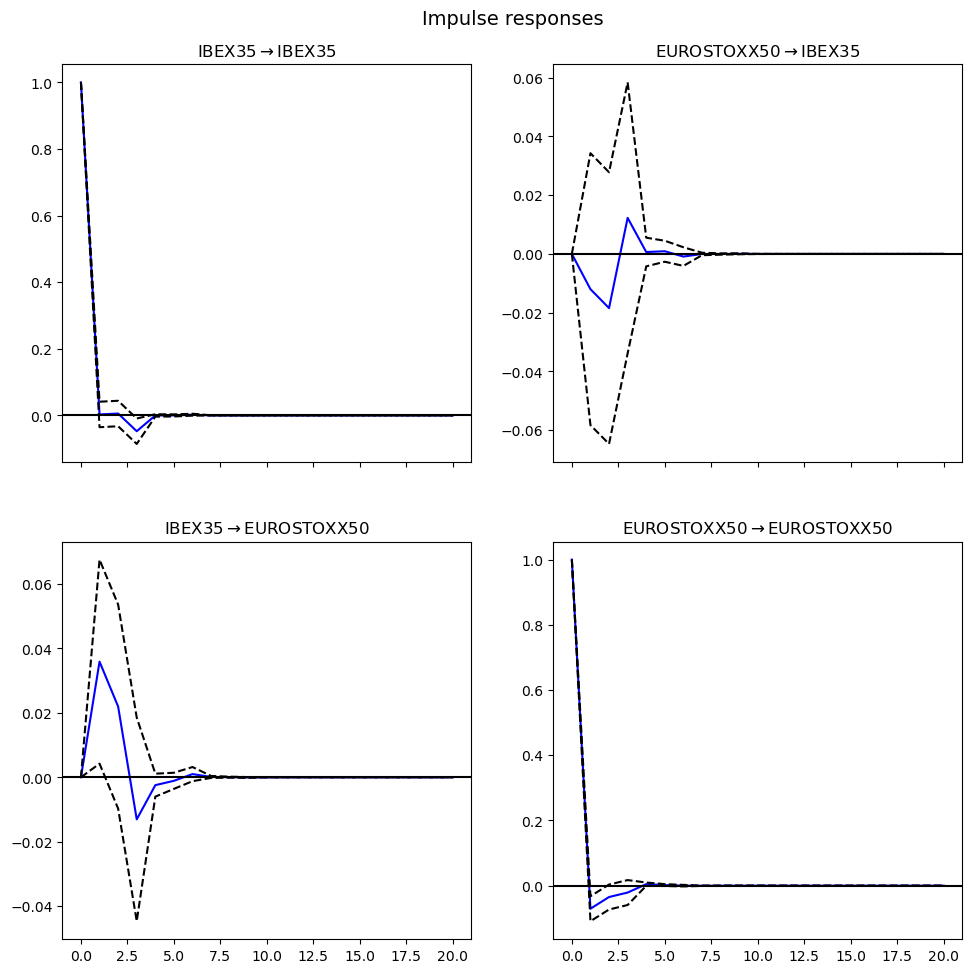

In [13]:
# Impulse Response Functions (IRFs) + export for Power BI

from pathlib import Path

# Horizon for IRFs (e.g. 20 trading days)
horizon = 20
irf = var_results.irf(horizon)

# 1) Plot IRFs and save figure
fig = irf.plot(orth=False)
fig.savefig(FIG_DIR / "irf_VAR_IBEX_EUROSTOXX.png", dpi=200, bbox_inches="tight")

print("IRF figure saved to:", FIG_DIR / "irf_VAR_IBEX_EUROSTOXX.png")

# 2) Build long-format IRF table for Power BI
names = var_results.names  # ["IBEX35", "EUROSTOXX50"]
arr = irf.irfs            # shape: (horizon+1, n_eqs, n_eqs)

rows = []
for h in range(arr.shape[0]):
    for i, response in enumerate(names):
        for j, shock in enumerate(names):
            rows.append({
                "Horizon": h,
                "Response": response,
                "Shock": shock,
                "IRF": arr[h, i, j]
            })

df_irf_long = pd.DataFrame(rows)

# Export CSV for Power BI
irf_path = DATA_POWERBI_DIR / "irf_VAR_IBEX_EUROSTOXX_long.csv"
df_irf_long.to_csv(irf_path, index=False)

print("✓ IRF long-format table exported to:", irf_path)

# Preview
display(df_irf_long.head())


**Interpretation of the IRFs:**

- Own-shocks (IBEX → IBEX and EUROSTOXX → EUROSTOXX):  
  As expected for return data, responses drop sharply to near zero after 1–2 days, consistent with the weak autocorrelation structure.

- Cross-market effects:
  - A shock in EUROSTOXX50 produces a small and short-lived reaction in IBEX35, stabilising quickly.  
  - A shock in IBEX35 produces a similar mild and temporary impact on EUROSTOXX50.  
  - Cross-responses peak around horizons 1–3 and then converge to zero, confirming that spillovers exist but are rapidly absorbed.

Overall, these IRFs reveal a fast decaying and symmetrical shock transmission between the two European indices, with no persistent long-run propagation, consistent with non cointegration and the stationary VAR structure.

The resulting CSV and figure serve as key inputs for the project’s Power BI dashboard.

## Analytical Summary of the Notebook: Unit Roots, Cointegration and VAR

This notebook evaluates the dynamic relationship between IBEX-35 and EUROSTOXX-50 using a sequence of econometric diagnostics designed to identify the correct representation of their joint behaviour. The analysis proceeds from integration tests to cointegration verification and finally to short-run multivariate modelling via VAR.

### Integration Properties

ADF and KPSS tests jointly confirm that both indices are integrated of order one, I(1), while their first differences (log-returns) are stationary, I(0). This behaviour is consistent with financial theory: equity prices follow stochastic trends, while returns fluctuate around a stable mean. These results constrain admissible model classes to either VECM (if cointegrated) or VAR in differences (if not).

### Long-Run Equilibrium Assessment

The Engle–Granger residual-based test provides no evidence of cointegration between the indices. The ADF statistic on residuals is insufficiently negative relative to critical thresholds, and the p-value (~0.14) indicates failure to reject the null of a unit root. This implies the absence of a shared long-term equilibrium path and rules out the use of VECM. Consequently, all modelling must target short-horizon dynamics exclusively.

### Short-Run Dynamics via VAR

Given the lack of cointegration, we estimate a VAR on stationary returns. Information criteria (AIC) select a VAR(3), capturing short-run interactions without imposing long-run structure.

Key features of the estimated VAR:

- Weak autoregressive structure in IBEX returns; most lagged coefficients are insignificant.
- Stronger short-run dependence in EUROSTOXX returns, including a significant response to IBEX at lag 1.
- High residual correlation (~0.77), indicating exposure to common shocks rather than strong predictive links.

The model is dynamically stable, with all characteristic roots lying outside the unit circle, enabling meaningful impulse-response analysis.

### Shock Transmission Mechanisms

Impulse Response Functions reveal:

- Rapid decay of own-shocks, typical of high-frequency equity returns.
- Small but measurable cross-market spillovers, with EUROSTOXX shocks affecting IBEX more than the reverse.
- No persistent propagation, consistent with the earlier finding of no long-run equilibrium and with efficient-market behaviour.

### Econometric Implications

The system exhibits:

- No long-run binding relation → VECM inappropriate.  
- Purely short-run interdependence → VAR in differences is the correct specification.  
- Fast shock absorption → market responses are immediate and transitory.  
- Asymmetric influence → EUROSTOXX exerts slightly stronger short-run pressure on IBEX.

Together, these findings provide a statistically coherent description of how the two markets move jointly: they react to similar risk factors and share high contemporaneous correlation, but they do not adjust toward a common equilibrium path. This analytical foundation supports the subsequent modules on volatility modelling and forecasting.
